in this notebook, FEF model in [Pesaran, M. Hashem; Zhou, Qiankun (2014): Estimation of Time-invariant Effects in Static Panel Data Models] (https://papers.ssrn.com/sol3/papers.cfm?abstract_id=2493312) is applied to estimate the effect of time-invariant variables, altruism, in the panel data.

this notebook is structured as followed:
- read in & processing data 
- examine missing value through plots
- implementation of FEF
- generate kernel density estimate plot using residual from FEF model
- conditional regression on sets that are more likely to make humanitarian donations 

I wrote this in Stata first to ensure the correctness of applying statistic models, then writing this again in Python for the completeness of the project and to practice.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from auxiliary import *
import zipfile
from linearmodels.panel import PooledOLS

import statsmodels.api as sm
import missingno as msno

pd.set_option('display.max_columns', 500)

sns.set_theme(style="ticks")

In [ ]:
with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall('')

### read in data
### set up dependent and independent variables
### examine missing value

In [4]:
long = pd.read_csv('data/result_long.csv')

#setting variables
#time invariants
x = ['altruism', 'posrecip', 'risktaking', 'patience', 'trust', 'negrecip']

#string variables
x_str = ['income_type', 'region']

#dummy vars
x_dummy = ['oecd', 'g20', 'oda_int', 'aid']

#year-varied vars 
x_year = ['demo_electoral', 'demo_gov', 'demo_participate', 'demo_culture', 'demo_liberty', 'govexpense',  'gdpcapita']

#year-varied gini index, contains large numbers of na
gni = ['gni']

#add constant
long_c = sm.add_constant(long)
long_y = long_c.assign(funding_capita= long_c['funding']/long_c['pop'])

# long_replace = long_y.replace({'funding_capita': np.nan}, 0)
long_index = long_y.set_index(['isocode', 'year'])
long_select_gni = long_index[['funding_capita'] + x + x_str + x_dummy + x_year + gni]
long_select_gni.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1368 entries, ('AFG', 2003) to ('ZWE', 2020)
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   funding_capita    874 non-null    float64
 1   altruism          1368 non-null   float64
 2   posrecip          1368 non-null   float64
 3   risktaking        1368 non-null   float64
 4   patience          1368 non-null   float64
 5   trust             1368 non-null   float64
 6   negrecip          1368 non-null   float64
 7   income_type       1368 non-null   object 
 8   region            1368 non-null   object 
 9   oecd              1368 non-null   int64  
 10  g20               1368 non-null   int64  
 11  oda_int           1368 non-null   int64  
 12  aid               1368 non-null   int64  
 13  demo_electoral    912 non-null    float64
 14  demo_gov          912 non-null    float64
 15  demo_participate  912 non-null    float64
 16  demo_culture      912

### graoh for examine missing value
- democratic have no data for 2007, 2009 and before 2006 simply bcs the assessment wasn't held in those years
- relatively small amount of missing value in govexpense & gdpcapita
- gni have large number of missing value for non-specific reason

<AxesSubplot:>

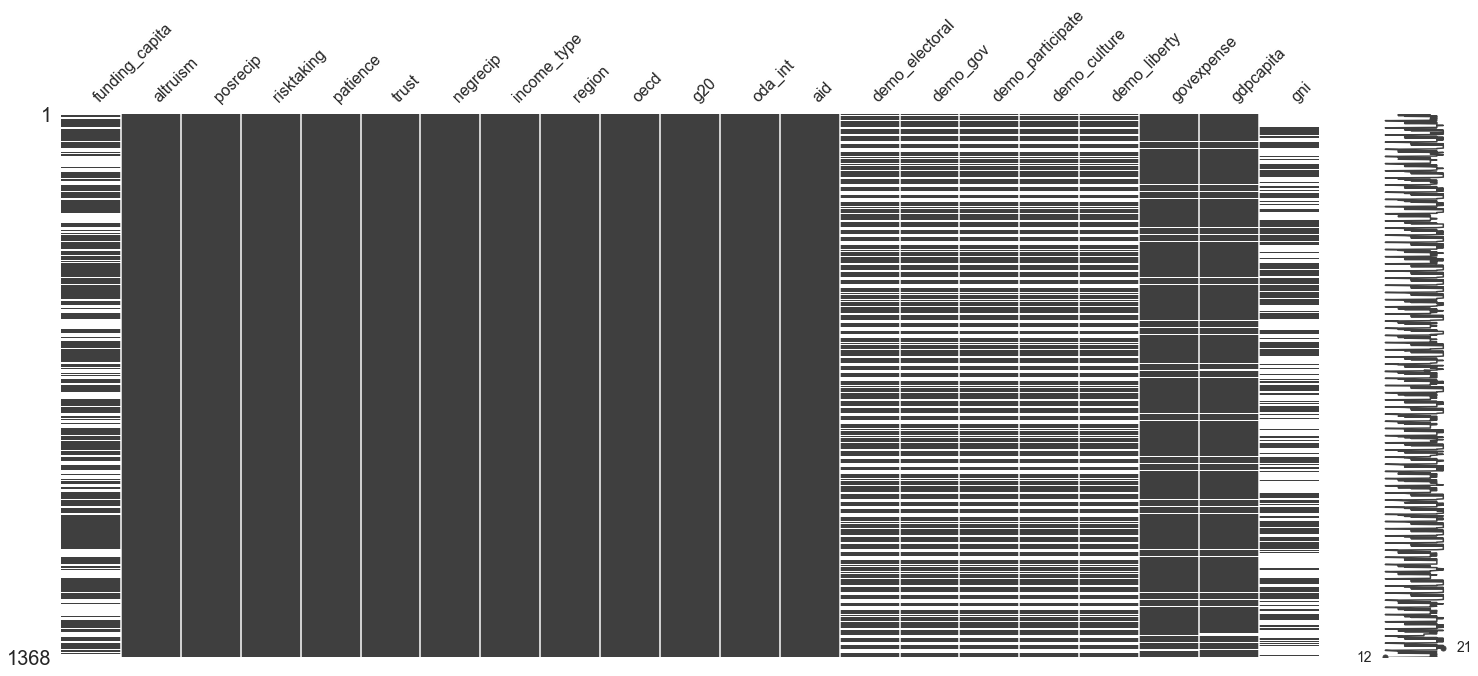

In [5]:
msno.matrix(long_select_gni)

### plot the relationship between y and x by missing gini index or not
### doesn't looks like missing at completely random
 in this notebook the result include and exclude gini index would be seperated, it's an influential factors based on past research, but the large number of missing value is not MACR and may causes bias. 

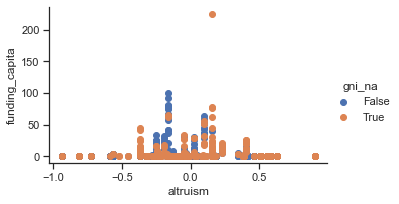

In [6]:
long_select_gni_na = long_select_gni.assign(gni_na=long_select_gni.gni.isnull())
fg = sns.FacetGrid(data=long_select_gni_na, hue='gni_na', aspect=1.61)
fg.map(plt.scatter, 'altruism', 'funding_capita').add_legend()


In [7]:
#drop na for regression
long_select = long_select_gni.drop(columns='gni')

df = long_select.dropna()
df_gni = long_select_gni.dropna()

df.head()


funding_capita  altruism  posrecip  risktaking  patience  \
isocode year                                                             
AFG     2008        0.865730  0.166455  0.289641    0.120764  -0.20136   
        2010        0.081544  0.166455  0.289641    0.120764  -0.20136   
        2011        0.000112  0.166455  0.289641    0.120764  -0.20136   
        2012        0.000096  0.166455  0.289641    0.120764  -0.20136   
        2013        0.000062  0.166455  0.289641    0.120764  -0.20136   

                 trust  negrecip income_type      region  oecd  g20  oda_int  \
isocode year                                                                   
AFG     2008  0.315964  0.254712  Low income  South Asia     0    0        0   
        2010  0.315964  0.254712  Low income  South Asia     0    0        0   
        2011  0.315964  0.254712  Low income  South Asia     0    0        0   
        2012  0.315964  0.254712  Low income  South Asia     0    0        0   
        2013  0.315964  0.254712  Low income  South Asia     0    0        0   

              aid  demo_electoral  demo_gov  demo_participate  demo_culture  \
isocode year                                                                  
AFG     2008    0            51.7       7.9              22.2          25.0   
        2010    0            25.0       7.9              27.8          25.0   
        2011    0            25.0       7.9              27.8          25.0   
        2012    0            25.0       7.9              27.8          25.0   
        2013    0            25.0       7.9              27.8          25.0   

              demo_liberty  govexpense   gdpcapita  
isocode year                                        
AFG     2008          44.1      20.918  364.660745  
        2010          38.2      20.801  543.303042  
        2011          38.2      21.937  591.162759  
        2012          38.2      25.028  641.871479  
        2013          38.2      24.977  637.165523

# FEF
### STEP 1: panel fixed effect model 

In [8]:
#with gni
mod = PooledOLS(df_gni.funding_capita, df_gni[x_year + gni])
pooled_res_gni = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True, entity_effects=True)

#without gni
mod = PooledOLS(df.funding_capita, df[x_year])
pooled_res = mod.fit(cov_type='clustered', cluster_entity=True, cluster_time=True, entity_effects=True)
pooled_res

Dep. Variable:,funding_capita,R-squared:,0.4799
Estimator:,PooledOLS,R-squared (Between):,0.6095
No. Observations:,635,R-squared (Within):,0.0206
Date:,"Sun, Jan 03 2021",R-squared (Overall):,0.4799
Time:,02:09:15,Log-likelihood,-2512.6
Cov. Estimator:,Clustered,,
,,F-statistic:,82.777
Entities:,76,P-value,0.0000
Avg Obs:,8.3553,Distribution:,"F(7,628)"
Min Obs:,0.0000,,
Max Obs:,12.000,F-statistic (robust):,4.9133


### step 2: predict residual by country

In [15]:
x_dict = {i: 'median' for i in (x + x_dummy)}
x_dict['res'] = 'mean'

#with gni
df_yhat_gni = df_gni.assign( yhat=pooled_res_gni.predict())
df_u_gni = df_yhat_gni.assign( res=df_yhat_gni.funding_capita - df_yhat_gni.yhat)
df2_gni = df_u_gni.groupby(['isocode'] + x_str).agg(x_dict).reset_index().set_index('isocode')

#without gni
df_yhat = df.assign( yhat=pooled_res.predict())
df_u = df_yhat.assign( res=df_yhat.funding_capita - df_yhat.yhat)
df2 = df_u.groupby(['isocode'] + x_str).agg(x_dict).reset_index().set_index('isocode')

df2.head()


,income_type,region,altruism,posrecip,risktaking,patience,trust,negrecip,oecd,g20,oda_int,aid,res
isocode,,,,,,,,,,,,,
AFG,Low income,South Asia,0.166455,0.289641,0.120764,-0.201360,0.315964,0.254712,0,0,0,0,3.359600
ARE,High income,Middle East & North Africa,0.154182,0.073196,0.086515,-0.091319,0.507108,0.221905,0,0,0,1,22.729965
ARG,Upper middle income,Latin America & Caribbean,0.027347,0.159679,0.041503,-0.229308,-0.206733,-0.140457,0,1,0,0,2.231422
AUS,High income,East Asia & Pacific,0.155331,0.069660,0.137137,0.657004,0.298973,0.022190,0,1,1,0,-14.731374
AUT,High income,Europe & Central Asia,-0.035363,0.161047,-0.061829,0.608285,0.154628,-0.055415,1,1,1,0,-16.719000


### step 3: regress time-invariant variables on residual

In [17]:
#transfer string to dummy
df_dummy_gni = pd.get_dummies(df2_gni)
df_dummy = pd.get_dummies(df2)

x_list = df_dummy_gni.columns.to_list()
x_list.remove('res')

#prevent colinearity
# x_list.remove('income_type_Low income')
x_list.remove('region_Sub-Saharan Africa')


#with gni
mod = sm.OLS(df_dummy_gni['res'], df_dummy_gni[x_list ])
res_gni = mod.fit()
res_gni.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    res   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                 -0.014
Method:                 Least Squares   F-statistic:                    0.9548
Date:                Sun, 03 Jan 2021   Prob (F-statistic):              0.525
Time:                        02:12:29   Log-Likelihood:                -200.15
No. Observations:                  59   AIC:                             438.3
Df Residuals:                      40   BIC:                             477.8
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
altruism                             -0.1570      5.587     -0.028      0.978     -11.448      11.134
posrecip                             -2.8758      6.635     -0.433      0.667     -16.287      10.535
risktaking                           -1.4718      8.193     -0.180      0.858     -18.031      15.087
patience                              3.7032      5.182      0.715      0.479      -6.770      14.177
trust                                11.2694      5.871      1.919      0.062      -0.596      23.135
negrecip                             -3.2604      5.486     -0.594      0.556     -14.349       7.828
oecd                                 -1.4372      5.965     -0.241      0.811     -13.494      10.619
g20                                  -2.5656      4.006     -0.640      0.526     -10.662       5.531
oda_int                              -0.5172      5.060     -0.102      0.919     -10.745       9.710
aid                                   2.5833      4.228      0.611      0.545      -5.962      11.129
income_type_High income              -0.0686      9.138     -0.008      0.994     -18.537      18.400
income_type_Lower middle income       6.1290      7.126      0.860      0.395      -8.273      20.531
income_type_Upper middle income       3.8128      8.767      0.435      0.666     -13.906      21.532
region_East Asia & Pacific           -8.8346      8.578     -1.030      0.309     -26.171       8.502
region_Europe & Central Asia          1.5021      8.522      0.176      0.861     -15.723      18.727
region_Latin America & Caribbean      0.8237      7.825      0.105      0.917     -14.992      16.639
region_Middle East & North Africa    -1.7148      7.933     -0.216      0.830     -17.747      14.318
region_North America                 -7.9097     11.201     -0.706      0.484     -30.548      14.729
region_South Asia                    -0.9525      8.681     -0.110      0.913     -18.497      16.592
==============================================================================
Omnibus:                       57.969   Durbin-Watson:                   1.557
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              499.793
Skew:                           2.471   Prob(JB):                    2.96e-109
Kurtosis:                      16.374   Cond. No.                         27.8
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
#without gni
mod = sm.OLS(df_dummy['res'], df_dummy[x_list ])
res = mod.fit()

res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                    res   R-squared (uncentered):                   0.232
Model:                            OLS   Adj. R-squared (uncentered):             -0.034
Method:                 Least Squares   F-statistic:                             0.8724
Date:                Sun, 03 Jan 2021   Prob (F-statistic):                       0.616
Time:                        02:12:40   Log-Likelihood:                         -248.65
No. Observations:                  74   AIC:                                      535.3
Df Residuals:                      55   BIC:                                      579.1
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
=====================================================================================================
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
altruism                             -1.2959      4.867     -0.266      0.791     -11.050       8.458
posrecip                             -3.8767      5.279     -0.734      0.466     -14.457       6.703
risktaking                            0.6697      4.779      0.140      0.889      -8.907      10.247
patience                              4.1929      4.037      1.039      0.304      -3.897      12.283
trust                                 7.4207      4.361      1.702      0.094      -1.319      16.161
negrecip                             -4.6156      4.586     -1.007      0.319     -13.805       4.574
oecd                                 -1.3320      5.385     -0.247      0.806     -12.124       9.460
g20                                  -3.8585      3.325     -1.160      0.251     -10.523       2.806
oda_int                              -0.4524      4.478     -0.101      0.920      -9.426       8.522
aid                                   2.4191      3.795      0.637      0.527      -5.187      10.025
income_type_High income              -0.0069      5.885     -0.001      0.999     -11.800      11.786
income_type_Lower middle income       2.9440      3.446      0.854      0.397      -3.962       9.850
income_type_Upper middle income       1.2215      4.462      0.274      0.785      -7.721      10.164
region_East Asia & Pacific           -4.2121      5.064     -0.832      0.409     -14.361       5.937
region_Europe & Central Asia          3.3000      4.871      0.677      0.501      -6.462      13.062
region_Latin America & Caribbean      2.5118      3.985      0.630      0.531      -5.474      10.497
region_Middle East & North Africa    -0.3273      4.791     -0.068      0.946      -9.928       9.274
region_North America                 -5.1982      8.474     -0.613      0.542     -22.181      11.784
region_South Asia                     4.0567      4.642      0.874      0.386      -5.245      13.359
==============================================================================
Omnibus:                       66.269   Durbin-Watson:                   1.688
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              652.234
Skew:                           2.430   Prob(JB):                    2.34e-142
Kurtosis:                      16.708   Cond. No.                         15.2
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### plot out residual in step 3
to see how the model fits

<AxesSubplot:ylabel='Density'>

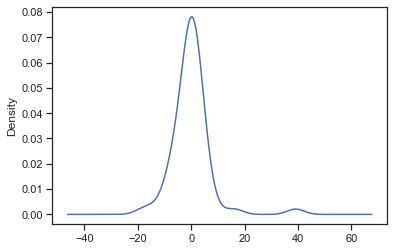

In [19]:
#with gni

df2_yhat_gni = df_dummy_gni.assign( yhat=res_gni.predict())
df2_u_gni = df2_yhat_gni.assign( res=df2_yhat_gni.res - df2_yhat_gni.yhat)
df2_u_gni.res.plot.kde()

<AxesSubplot:ylabel='Density'>

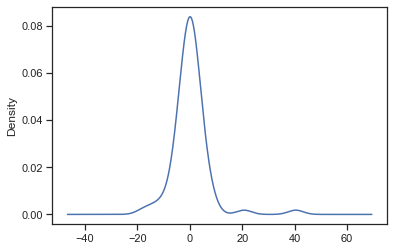

In [157]:
#without gni
df2_yhat = df_dummy.assign( yhat=res.predict())
df2_u = df2_yhat.assign( res=df2_yhat.res - df2_yhat.yhat)
df2_u.res.plot.kde()

### condition on possible set that is more likely to donate

In [20]:
query = ['`income_type_High income` == 1',
        'oecd == 1',
        'g20 == 1',
        'oda_int == 1',
        'aid == 0']

for i in query:
    df_query = df_dummy_gni.query(i)
    mod = sm.OLS(df_query['res'], df_query[x_list])
    res_gni = mod.fit()
    print(i)
    print(res_gni.summary())

`income_type_High income` == 1
                            OLS Regression Results                            
Dep. Variable:                    res   R-squared:                       0.362
Model:                            OLS   Adj. R-squared:                 -0.383
Method:                 Least Squares   F-statistic:                    0.4855
Date:                Sun, 03 Jan 2021   Prob (F-statistic):              0.901
Time:                        02:13:22   Log-Likelihood:                -98.789
No. Observations:                  27   AIC:                             227.6
Df Residuals:                      12   BIC:                             247.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------